# My First MAF

**Goal:** Implement a simple MAF to transform a 2d Gaussian into the $p_T$ distributions for the 2b data in the hh analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append("../pytorch-flows")
import flows as fnn

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import copy

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

I'm going to just be cutting and pasting some code from Ilya's `main.py` function to train a MAF with 5 blocks.

In [4]:
modules = []

num_inputs = 2
num_hidden = 64
num_cond_inputs = None
act = 'relu'

for _ in range(5):
        modules += [
            fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
            fnn.BatchNormFlow(num_inputs),
            fnn.Reverse(num_inputs)
        ]
               
model = fnn.FlowSequential(*modules)

for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

I didn't want to spend a ton of time doing pre-processing for a model that I was just trying to get working, so I decided to start with the illustration they have in Figure 1 of the [MAF paper](https://arxiv.org/abs/1705.07057).

In [5]:
Ntrain = 100000

x2 = np.random.randn(Ntrain) * 4
x1 = np.random.randn(Ntrain) + 0.25 * np.power(x2,2)

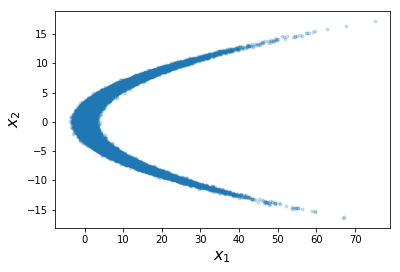

In [6]:
plt.scatter(x1, x2, marker='.', alpha=0.2)
plt.xlabel('$x_1$',fontsize=16)
plt.ylabel('$x_2$',fontsize=16)
plt.show()

Then for the input distribution we want to map into, use a multi-variate Gaussian.

In [7]:
mean = np.zeros(num_inputs)
cov = np.eye(num_inputs)
u1,u2 = np.random.multivariate_normal(mean, cov, Ntrain).T

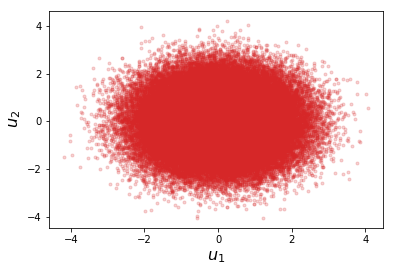

In [8]:
plt.scatter(u1, u2, color='C3', marker='.', alpha=0.2)
plt.xlabel('$u_1$',fontsize=16)
plt.ylabel('$u_2$',fontsize=16)
plt.show()

In [ ]:
class toyDataset(Dataset):
    """EM showers dataset"""
    
    def __init__(self, N):
        """
        
        Inputs:
        - N: samples to generate
        
        """
        
        x2 = np.random.randn(N) * 4
        x1 = np.random.randn(N) + 0.25 * np.power(x2,2)
        
        x = np.vstack([x1,x2]).T
        self.x = torch.from_numpy(x)
        
    def __len__(self):
        return self.x.shape[1] 

    def __getitem__(self, idx):
        return self.x[idx]


In [ ]:
trainFrac = .6
valFrac = .1
testFrac = .3

In [ ]:
def getDataLoaders(batch_size=128, N=100000):
    '''
    Input: 
        batch_size
        N: Number of events 
 
    Returns: loader_train, loader_val, loader_test
        DataLoaders for the train, val, and test sets
 
    '''
    
    dset = toyDataset(N=N)
     
    idxTrain = [j for j in range(int(trainFrac*N))]
    idxVal   = [j for j in range(int(trainFrac*N), int((trainFrac+valFrac)*N))]
    idxTest  = [j for j in range(int((trainFrac+valFrac)*N), N)]
    
    loader_train = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(idxTrain))
    loader_val = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(idxVal))
    loader_test = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(idxTest))

    return loader_train, loader_val, loader_test

In [ ]:
global_step = 0

In [ ]:
loader_train, loader_val, loader_test = getDataLoaders()

In [ ]:
type(loader_train)

torch.utils.data.dataloader.DataLoader

In [ ]:
def train(epoch):
    global global_step
    model.train()
    train_loss = 0

    pbar = tqdm(total=len(loader_train))
    
    
    for batch_idx, data in enumerate(loader_train):

        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
            else:
                cond_data = None
            data = data[0].float()
        else:
            data = data.float()
            
        data = data.to(device)
        optimizer.zero_grad()
        loss = -model.log_probs(data, None).mean()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        pbar.update(data.size(0))
        pbar.set_description('Train, Log likelihood in nats: {:.6f}'.format(
            -train_loss / (batch_idx + 1)))
        
        global_step += 1
        
    pbar.close()
      

In [ ]:
#train(0)

In [ ]:
def validate(epoch, model, loader, prefix='Validation'):
    global global_step

    model.eval()
    val_loss = 0

    pbar = tqdm(total=len(loader))
    pbar.set_description('Eval')
    for batch_idx, data in enumerate(loader):
        
        data = data.float()
        data = data.to(device)
        
        with torch.no_grad():
            val_loss += -model.log_probs(data, None).sum().item()  # sum up batch loss
            
        pbar.update(data.size(0))
        pbar.set_description('Val, Log likelihood in nats: {:.6f}'.format(
            -val_loss / pbar.n))

    pbar.close()
    return val_loss / len(loader.dataset)


Let's transform back to the random numbers to see how the model is converging!

In [ ]:
model.eval()
val_loss = 0
us = []


pbar = tqdm(total=len(loader_val))
pbar.set_description('Eval')

for batch_idx, data in enumerate(loader_val):
        
    data = data.float()
        
    data = data.to(device)
    with torch.no_grad():
        val_loss += -model.log_probs(data, None).sum().item()  # sum up batch loss
        
        u, _ = model.forward(data,mode='direct')
        us.append(u.cpu())
          
    pbar.update(data.size(0))
    pbar.set_description('Val, Log likelihood in nats: {:.6f}'.format(
        -val_loss / pbar.n))




Val, Log likelihood in nats: nan: : 10000it [00:01, 7155.94it/s]

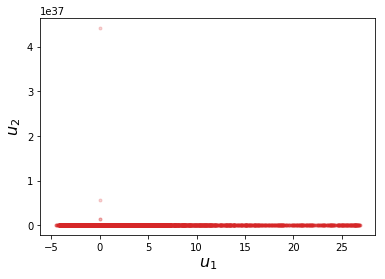

In [ ]:
u1,u2 = np.concatenate(us).T
plt.scatter(u1,u2, color='C3', marker='.', alpha=0.2)
plt.xlabel('$u_1$',fontsize=16)
plt.ylabel('$u_2$',fontsize=16)
plt.show()

**Conclusion:** After one iteration, the model has not yet converged.

Let's try training for 20 epochs!

In [ ]:
# I
# with torch.no_grad():
#     model(loader_train.dataset.tensors[0].to(data.device))

In [ ]:
best_validation_loss = float('inf')
best_validation_epoch = 0
best_model = model

for epoch in range(20):
    print('\nEpoch: {}'.format(epoch))

    train(epoch)
    validation_loss = validate(epoch, model, loader_val)

    if epoch - best_validation_epoch >= 30:
        break

    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        #best_model = copy.deepcopy(model)
        torch.save(model.state_dict(), "bestModel.pt")

    print(
        'Best validation at epoch {}: Average Log Likelihood in nats: {:.4f}'.
        format(best_validation_epoch, -best_validation_loss))

model.load_state_dict(torch.load("bestModel.pt"))
    


Train, Log likelihood in nats: -6.318095:  55%|█████▍    | 256/469 [00:00<00:00, 1177.15it/s]


Epoch: 0



Train, Log likelihood in nats: -6.265496:  82%|████████▏ | 384/469 [00:00<00:00, 1177.15it/s]
Train, Log likelihood in nats: -6.265496: : 512it [00:00, 1429.41it/s]                       
Train, Log likelihood in nats: -6.289476: : 512it [00:00, 1429.41it/s]
Train, Log likelihood in nats: -6.192498: : 640it [00:00, 1429.41it/s]
Train, Log likelihood in nats: -6.119021: : 768it [00:00, 1429.41it/s]
Train, Log likelihood in nats: -6.119021: : 896it [00:00, 1679.85it/s]
Train, Log likelihood in nats: -6.053897: : 896it [00:00, 1679.85it/s]
Train, Log likelihood in nats: -6.034354: : 1024it [00:00, 1679.85it/s]
Train, Log likelihood in nats: -5.978407: : 1152it [00:00, 1679.85it/s]
Train, Log likelihood in nats: -5.978407: : 1280it [00:00, 1943.52it/s]
Train, Log likelihood in nats: -5.949963: : 1280it [00:00, 1943.52it/s]
Train, Log likelihood in nats: -5.908833: : 1408it [00:00, 1943.52it/s]
Train, Log likelihood in nats: -5.895085: : 1536it [00:00, 1943.52it/s]
Train, Log likelihood in

Train, Log likelihood in nats: -4.954654: : 21248it [00:06, 3580.90it/s]
Train, Log likelihood in nats: -4.951422: : 21376it [00:06, 3580.90it/s]
Train, Log likelihood in nats: -4.948751: : 21504it [00:06, 3580.90it/s]
Train, Log likelihood in nats: -4.948751: : 21632it [00:06, 3511.79it/s]
Train, Log likelihood in nats: -4.944168: : 21632it [00:06, 3511.79it/s]
Train, Log likelihood in nats: -4.940296: : 21760it [00:06, 3511.79it/s]
Train, Log likelihood in nats: -4.936595: : 21888it [00:06, 3511.79it/s]
Train, Log likelihood in nats: -4.933157: : 22016it [00:06, 3511.79it/s]
Train, Log likelihood in nats: -4.933157: : 22144it [00:06, 3620.10it/s]
Train, Log likelihood in nats: -4.930850: : 22144it [00:06, 3620.10it/s]
Train, Log likelihood in nats: -4.926828: : 22272it [00:06, 3620.10it/s]
Train, Log likelihood in nats: -4.922723: : 22400it [00:06, 3620.10it/s]
Train, Log likelihood in nats: -4.922723: : 22528it [00:06, 3682.24it/s]
Train, Log likelihood in nats: -4.919537: : 22528it

Train, Log likelihood in nats: -4.685421: : 42496it [00:12, 2839.91it/s]
Train, Log likelihood in nats: -4.684559: : 42624it [00:12, 2839.91it/s]
Train, Log likelihood in nats: -4.683519: : 42752it [00:12, 2839.91it/s]
Train, Log likelihood in nats: -4.683519: : 42880it [00:12, 2644.66it/s]
Train, Log likelihood in nats: -4.682481: : 42880it [00:12, 2644.66it/s]
Train, Log likelihood in nats: -4.681388: : 43008it [00:12, 2644.66it/s]
Train, Log likelihood in nats: -4.680355: : 43136it [00:12, 2644.66it/s]
Train, Log likelihood in nats: -4.678812: : 43264it [00:12, 2644.66it/s]
Train, Log likelihood in nats: -4.678812: : 43392it [00:12, 2878.68it/s]
Train, Log likelihood in nats: -4.678005: : 43392it [00:12, 2878.68it/s]
Train, Log likelihood in nats: -4.677485: : 43520it [00:12, 2878.68it/s]
Train, Log likelihood in nats: -4.676149: : 43648it [00:12, 2878.68it/s]
Train, Log likelihood in nats: -4.676149: : 43776it [00:12, 2964.18it/s]
Train, Log likelihood in nats: -4.674902: : 43776it

Val, Log likelihood in nats: -4.379004: : 4224it [00:00, 15849.34it/s]
Val, Log likelihood in nats: -4.378730: : 4352it [00:00, 15849.34it/s]
Val, Log likelihood in nats: -4.384410: : 4480it [00:00, 15849.34it/s]
Val, Log likelihood in nats: -4.382431: : 4608it [00:00, 15849.34it/s]
Val, Log likelihood in nats: -4.384142: : 4736it [00:00, 15849.34it/s]
Val, Log likelihood in nats: -4.384307: : 4864it [00:00, 15849.34it/s]
Val, Log likelihood in nats: -4.384307: : 4992it [00:00, 16003.93it/s]
Val, Log likelihood in nats: -4.384085: : 4992it [00:00, 16003.93it/s]
Val, Log likelihood in nats: -4.380638: : 5120it [00:00, 16003.93it/s]
Val, Log likelihood in nats: -4.378435: : 5248it [00:00, 16003.93it/s]
Val, Log likelihood in nats: -4.376859: : 5376it [00:00, 16003.93it/s]
Val, Log likelihood in nats: -4.373139: : 5504it [00:00, 16003.93it/s]
Val, Log likelihood in nats: -4.375562: : 5632it [00:00, 16003.93it/s]
Val, Log likelihood in nats: -4.378297: : 5760it [00:00, 16003.93it/s]
Val, L

Best validation at epoch 0: Average Log Likelihood in nats: -21831.9123

Epoch: 1



Train, Log likelihood in nats: -4.343655: : 896it [00:00, 4023.92it/s]
Train, Log likelihood in nats: -4.343655: : 1024it [00:00, 4026.81it/s]
Train, Log likelihood in nats: -4.321777: : 1024it [00:00, 4026.81it/s]
Train, Log likelihood in nats: -4.330240: : 1152it [00:00, 4026.81it/s]
Train, Log likelihood in nats: -4.330092: : 1280it [00:00, 4026.81it/s]
Train, Log likelihood in nats: -4.337176: : 1408it [00:00, 4026.81it/s]
Train, Log likelihood in nats: -4.337176: : 1536it [00:00, 4090.60it/s]
Train, Log likelihood in nats: -4.330629: : 1536it [00:00, 4090.60it/s]
Train, Log likelihood in nats: -4.313586: : 1664it [00:00, 4090.60it/s]
Train, Log likelihood in nats: -4.310710: : 1792it [00:00, 4090.60it/s]
Train, Log likelihood in nats: -4.315704: : 1920it [00:00, 4090.60it/s]
Train, Log likelihood in nats: -4.315704: : 2048it [00:00, 4041.30it/s]
Train, Log likelihood in nats: -4.322807: : 2048it [00:00, 4041.30it/s]
Train, Log likelihood in nats: -4.329714: : 2176it [00:00, 4041.

Train, Log likelihood in nats: -4.314097: : 22016it [00:06, 3164.95it/s]
Train, Log likelihood in nats: -4.313975: : 22144it [00:06, 3164.95it/s]
Train, Log likelihood in nats: -4.313660: : 22272it [00:06, 3164.95it/s]
Train, Log likelihood in nats: -4.313660: : 22400it [00:06, 3167.91it/s]
Train, Log likelihood in nats: -4.313038: : 22400it [00:06, 3167.91it/s]
Train, Log likelihood in nats: -4.312110: : 22528it [00:06, 3167.91it/s]
Train, Log likelihood in nats: -4.313139: : 22656it [00:06, 3167.91it/s]
Train, Log likelihood in nats: -4.313139: : 22784it [00:06, 3100.04it/s]
Train, Log likelihood in nats: -4.313670: : 22784it [00:06, 3100.04it/s]
Train, Log likelihood in nats: -4.313096: : 22912it [00:06, 3100.04it/s]
Train, Log likelihood in nats: -4.312762: : 23040it [00:06, 3100.04it/s]
Train, Log likelihood in nats: -4.312762: : 23168it [00:06, 3029.93it/s]
Train, Log likelihood in nats: -4.312608: : 23168it [00:06, 3029.93it/s]
Train, Log likelihood in nats: -4.313300: : 23296it

Train, Log likelihood in nats: -4.310387: : 43264it [00:12, 3385.11it/s]
Train, Log likelihood in nats: -4.311004: : 43392it [00:12, 3385.11it/s]
Train, Log likelihood in nats: -4.310384: : 43520it [00:12, 3385.11it/s]
Train, Log likelihood in nats: -4.310166: : 43648it [00:12, 3385.11it/s]
Train, Log likelihood in nats: -4.310166: : 43776it [00:12, 3537.07it/s]
Train, Log likelihood in nats: -4.309951: : 43776it [00:12, 3537.07it/s]
Train, Log likelihood in nats: -4.309540: : 43904it [00:12, 3537.07it/s]
Train, Log likelihood in nats: -4.309528: : 44032it [00:12, 3537.07it/s]
Train, Log likelihood in nats: -4.309528: : 44160it [00:12, 3403.87it/s]
Train, Log likelihood in nats: -4.309644: : 44160it [00:12, 3403.87it/s]
Train, Log likelihood in nats: -4.309608: : 44288it [00:12, 3403.87it/s]
Train, Log likelihood in nats: -4.309722: : 44416it [00:12, 3403.87it/s]
Train, Log likelihood in nats: -4.309722: : 44544it [00:12, 3438.79it/s]
Train, Log likelihood in nats: -4.309296: : 44544it

Val, Log likelihood in nats: -4.298338: : 5120it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.294153: : 5120it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.294377: : 5248it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.293654: : 5376it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.297189: : 5504it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.302319: : 5632it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.304780: : 5760it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.303291: : 5888it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.308889: : 6016it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.307511: : 6144it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.311488: : 6272it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.313214: : 6400it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.313652: : 6528it [00:00, 12210.03it/s]
Val, Log likelihood in nats: -4.313652: : 6656it [00:00, 12851.58it/s]
Val, L

Best validation at epoch 1: Average Log Likelihood in nats: -21534.8398

Epoch: 2



Train, Log likelihood in nats: -4.228127: : 768it [00:00, 3543.65it/s]
Train, Log likelihood in nats: -4.244192: : 768it [00:00, 3543.65it/s]
Train, Log likelihood in nats: -4.243123: : 896it [00:00, 3543.65it/s]
Train, Log likelihood in nats: -4.235544: : 1024it [00:00, 3543.65it/s]
Train, Log likelihood in nats: -4.235544: : 1152it [00:00, 3614.30it/s]
Train, Log likelihood in nats: -4.229579: : 1152it [00:00, 3614.30it/s]
Train, Log likelihood in nats: -4.228891: : 1280it [00:00, 3614.30it/s]
Train, Log likelihood in nats: -4.220837: : 1408it [00:00, 3614.30it/s]
Train, Log likelihood in nats: -4.219164: : 1536it [00:00, 3614.30it/s]
Train, Log likelihood in nats: -4.219164: : 1664it [00:00, 3741.91it/s]
Train, Log likelihood in nats: -4.207075: : 1664it [00:00, 3741.91it/s]
Train, Log likelihood in nats: -4.211748: : 1792it [00:00, 3741.91it/s]
Train, Log likelihood in nats: -4.208792: : 1920it [00:00, 3741.91it/s]
Train, Log likelihood in nats: -4.208792: : 2048it [00:00, 3718.69

Train, Log likelihood in nats: -4.284124: : 21888it [00:06, 3731.73it/s]
Train, Log likelihood in nats: -4.284124: : 22016it [00:06, 3800.00it/s]
Train, Log likelihood in nats: -4.284353: : 22016it [00:06, 3800.00it/s]
Train, Log likelihood in nats: -4.283879: : 22144it [00:06, 3800.00it/s]
Train, Log likelihood in nats: -4.284068: : 22272it [00:06, 3800.00it/s]
Train, Log likelihood in nats: -4.284015: : 22400it [00:06, 3800.00it/s]
Train, Log likelihood in nats: -4.284015: : 22528it [00:06, 3599.15it/s]
Train, Log likelihood in nats: -4.286004: : 22528it [00:06, 3599.15it/s]
Train, Log likelihood in nats: -4.286258: : 22656it [00:06, 3599.15it/s]
Train, Log likelihood in nats: -4.285747: : 22784it [00:06, 3599.15it/s]
Train, Log likelihood in nats: -4.285747: : 22912it [00:06, 3276.60it/s]
Train, Log likelihood in nats: -4.285638: : 22912it [00:06, 3276.60it/s]
Train, Log likelihood in nats: -4.286041: : 23040it [00:06, 3276.60it/s]
Train, Log likelihood in nats: -4.285510: : 23168it

Train, Log likelihood in nats: -4.284108: : 42496it [00:12, 3061.11it/s]
Train, Log likelihood in nats: -4.284076: : 42624it [00:12, 3061.11it/s]
Train, Log likelihood in nats: -4.284206: : 42752it [00:12, 3061.11it/s]
Train, Log likelihood in nats: -4.284206: : 42880it [00:12, 3160.46it/s]
Train, Log likelihood in nats: -4.284080: : 42880it [00:12, 3160.46it/s]
Train, Log likelihood in nats: -4.284387: : 43008it [00:12, 3160.46it/s]
Train, Log likelihood in nats: -4.284038: : 43136it [00:12, 3160.46it/s]
Train, Log likelihood in nats: -4.284038: : 43264it [00:12, 3122.27it/s]
Train, Log likelihood in nats: -4.284319: : 43264it [00:12, 3122.27it/s]
Train, Log likelihood in nats: -4.284096: : 43392it [00:12, 3122.27it/s]
Train, Log likelihood in nats: -4.284046: : 43520it [00:12, 3122.27it/s]
Train, Log likelihood in nats: -4.284046: : 43648it [00:12, 3216.65it/s]
Train, Log likelihood in nats: -4.283820: : 43648it [00:12, 3216.65it/s]
Train, Log likelihood in nats: -4.283888: : 43776it

Val, Log likelihood in nats: -4.309708: : 4096it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.309206: : 4224it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.304632: : 4352it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.299367: : 4480it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.298381: : 4608it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.299673: : 4736it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.300359: : 4864it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.301813: : 4992it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.301152: : 5120it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.301193: : 5248it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.300313: : 5376it [00:00, 11688.63it/s]
Val, Log likelihood in nats: -4.300313: : 5504it [00:00, 12079.29it/s]
Val, Log likelihood in nats: -4.302985: : 5504it [00:00, 12079.29it/s]
Val, Log likelihood in nats: -4.302772: : 5632it [00:00, 12079.29it/s]
Val, L

Best validation at epoch 2: Average Log Likelihood in nats: -21478.7210

Epoch: 3



Train, Log likelihood in nats: -4.225585: : 1024it [00:00, 4679.49it/s]
Train, Log likelihood in nats: -4.229967: : 1024it [00:00, 4679.49it/s]
Train, Log likelihood in nats: -4.228878: : 1152it [00:00, 4679.49it/s]
Train, Log likelihood in nats: -4.234232: : 1280it [00:00, 4679.49it/s]
Train, Log likelihood in nats: -4.241592: : 1408it [00:00, 4679.49it/s]
Train, Log likelihood in nats: -4.241592: : 1536it [00:00, 4590.03it/s]
Train, Log likelihood in nats: -4.246202: : 1536it [00:00, 4590.03it/s]
Train, Log likelihood in nats: -4.253573: : 1664it [00:00, 4590.03it/s]
Train, Log likelihood in nats: -4.252332: : 1792it [00:00, 4590.03it/s]
Train, Log likelihood in nats: -4.252666: : 1920it [00:00, 4590.03it/s]
Train, Log likelihood in nats: -4.252666: : 2048it [00:00, 4495.10it/s]
Train, Log likelihood in nats: -4.260225: : 2048it [00:00, 4495.10it/s]
Train, Log likelihood in nats: -4.251361: : 2176it [00:00, 4495.10it/s]
Train, Log likelihood in nats: -4.249534: : 2304it [00:00, 4495

Train, Log likelihood in nats: -4.258818: : 22784it [00:05, 3404.64it/s]
Train, Log likelihood in nats: -4.260275: : 22784it [00:05, 3404.64it/s]
Train, Log likelihood in nats: -4.260709: : 22912it [00:05, 3404.64it/s]
Train, Log likelihood in nats: -4.261258: : 23040it [00:05, 3404.64it/s]
Train, Log likelihood in nats: -4.260891: : 23168it [00:05, 3404.64it/s]
Train, Log likelihood in nats: -4.260891: : 23296it [00:05, 3540.88it/s]
Train, Log likelihood in nats: -4.260907: : 23296it [00:05, 3540.88it/s]
Train, Log likelihood in nats: -4.261161: : 23424it [00:05, 3540.88it/s]
Train, Log likelihood in nats: -4.261329: : 23552it [00:05, 3540.88it/s]
Train, Log likelihood in nats: -4.261178: : 23680it [00:05, 3540.88it/s]
Train, Log likelihood in nats: -4.261178: : 23808it [00:06, 3651.82it/s]
Train, Log likelihood in nats: -4.260369: : 23808it [00:06, 3651.82it/s]
Train, Log likelihood in nats: -4.260145: : 23936it [00:06, 3651.82it/s]
Train, Log likelihood in nats: -4.260037: : 24064it

Train, Log likelihood in nats: -4.260410: : 43904it [00:11, 3779.69it/s]
Train, Log likelihood in nats: -4.260437: : 44032it [00:11, 3779.69it/s]
Train, Log likelihood in nats: -4.260437: : 44160it [00:11, 3814.38it/s]
Train, Log likelihood in nats: -4.259964: : 44160it [00:11, 3814.38it/s]
Train, Log likelihood in nats: -4.260059: : 44288it [00:11, 3814.38it/s]
Train, Log likelihood in nats: -4.260309: : 44416it [00:11, 3814.38it/s]
Train, Log likelihood in nats: -4.260272: : 44544it [00:11, 3814.38it/s]
Train, Log likelihood in nats: -4.260272: : 44672it [00:11, 3727.25it/s]
Train, Log likelihood in nats: -4.260253: : 44672it [00:11, 3727.25it/s]
Train, Log likelihood in nats: -4.260212: : 44800it [00:11, 3727.25it/s]
Train, Log likelihood in nats: -4.260294: : 44928it [00:12, 3727.25it/s]
Train, Log likelihood in nats: -4.260294: : 45056it [00:12, 3347.85it/s]
Train, Log likelihood in nats: -4.259942: : 45056it [00:12, 3347.85it/s]
Train, Log likelihood in nats: -4.259928: : 45184it

Val, Log likelihood in nats: -4.280927: : 5888it [00:00, 13401.33it/s]
Val, Log likelihood in nats: -4.277499: : 6016it [00:00, 13401.33it/s]
Val, Log likelihood in nats: -4.277420: : 6144it [00:00, 13401.33it/s]
Val, Log likelihood in nats: -4.274772: : 6272it [00:00, 13401.33it/s]
Val, Log likelihood in nats: -4.274092: : 6400it [00:00, 13401.33it/s]
Val, Log likelihood in nats: -4.273954: : 6528it [00:00, 13401.33it/s]
Val, Log likelihood in nats: -4.271555: : 6656it [00:00, 13401.33it/s]
Val, Log likelihood in nats: -4.271814: : 6784it [00:00, 13401.33it/s]
Val, Log likelihood in nats: -4.268995: : 6912it [00:00, 13401.33it/s]
Val, Log likelihood in nats: -4.268995: : 7040it [00:00, 13593.46it/s]
Val, Log likelihood in nats: -4.264964: : 7040it [00:00, 13593.46it/s]
Val, Log likelihood in nats: -4.265075: : 7168it [00:00, 13593.46it/s]
Val, Log likelihood in nats: -4.267498: : 7296it [00:00, 13593.46it/s]
Val, Log likelihood in nats: -4.266374: : 7424it [00:00, 13593.46it/s]
Val, L

Best validation at epoch 3: Average Log Likelihood in nats: -21354.6461

Epoch: 4



Train, Log likelihood in nats: -4.242950: : 896it [00:00, 3872.08it/s]
Train, Log likelihood in nats: -4.262296: : 896it [00:00, 3872.08it/s]
Train, Log likelihood in nats: -4.275507: : 1024it [00:00, 3872.08it/s]
Train, Log likelihood in nats: -4.291954: : 1152it [00:00, 3872.08it/s]
Train, Log likelihood in nats: -4.286505: : 1280it [00:00, 3872.08it/s]
Train, Log likelihood in nats: -4.286505: : 1408it [00:00, 4043.38it/s]
Train, Log likelihood in nats: -4.294595: : 1408it [00:00, 4043.38it/s]
Train, Log likelihood in nats: -4.285784: : 1536it [00:00, 4043.38it/s]
Train, Log likelihood in nats: -4.284818: : 1664it [00:00, 4043.38it/s]
Train, Log likelihood in nats: -4.281907: : 1792it [00:00, 4043.38it/s]
Train, Log likelihood in nats: -4.281907: : 1920it [00:00, 4031.27it/s]
Train, Log likelihood in nats: -4.285019: : 1920it [00:00, 4031.27it/s]
Train, Log likelihood in nats: -4.277396: : 2048it [00:00, 4031.27it/s]
Train, Log likelihood in nats: -4.277560: : 2176it [00:00, 4031.2

Train, Log likelihood in nats: -4.264354: : 22144it [00:06, 3155.20it/s]
Train, Log likelihood in nats: -4.263893: : 22272it [00:06, 3155.20it/s]
Train, Log likelihood in nats: -4.263893: : 22400it [00:06, 3347.52it/s]
Train, Log likelihood in nats: -4.263735: : 22400it [00:06, 3347.52it/s]
Train, Log likelihood in nats: -4.263658: : 22528it [00:06, 3347.52it/s]
Train, Log likelihood in nats: -4.262826: : 22656it [00:06, 3347.52it/s]
Train, Log likelihood in nats: -4.262826: : 22784it [00:06, 3433.17it/s]
Train, Log likelihood in nats: -4.262809: : 22784it [00:06, 3433.17it/s]
Train, Log likelihood in nats: -4.262923: : 22912it [00:06, 3433.17it/s]
Train, Log likelihood in nats: -4.262820: : 23040it [00:06, 3433.17it/s]
Train, Log likelihood in nats: -4.263282: : 23168it [00:06, 3433.17it/s]
Train, Log likelihood in nats: -4.263282: : 23296it [00:06, 3568.83it/s]
Train, Log likelihood in nats: -4.263249: : 23296it [00:06, 3568.83it/s]
Train, Log likelihood in nats: -4.263471: : 23424it

Train, Log likelihood in nats: -4.257523: : 42880it [00:12, 3288.02it/s]
Train, Log likelihood in nats: -4.257429: : 43008it [00:12, 3288.02it/s]
Train, Log likelihood in nats: -4.256735: : 43136it [00:12, 3288.02it/s]
Train, Log likelihood in nats: -4.256735: : 43264it [00:12, 3259.18it/s]
Train, Log likelihood in nats: -4.256739: : 43264it [00:12, 3259.18it/s]
Train, Log likelihood in nats: -4.256347: : 43392it [00:12, 3259.18it/s]
Train, Log likelihood in nats: -4.257093: : 43520it [00:12, 3259.18it/s]
Train, Log likelihood in nats: -4.257093: : 43648it [00:12, 3184.91it/s]
Train, Log likelihood in nats: -4.257329: : 43648it [00:12, 3184.91it/s]
Train, Log likelihood in nats: -4.257355: : 43776it [00:12, 3184.91it/s]
Train, Log likelihood in nats: -4.257311: : 43904it [00:12, 3184.91it/s]
Train, Log likelihood in nats: -4.257311: : 44032it [00:12, 3281.63it/s]
Train, Log likelihood in nats: -4.257106: : 44032it [00:12, 3281.63it/s]

In [ ]:
model.eval()
val_loss = 0
us = []


pbar = tqdm(total=len(loader_val))
pbar.set_description('Eval')

for batch_idx, data in enumerate(loader_val):
        
    data = data.float()
        
    data = data.to(device)
    with torch.no_grad():
        val_loss += -model.log_probs(data, None).sum().item()  # sum up batch loss
        
        u, _ = model.forward(data,mode='direct')
        us.append(u.cpu())

u1,u2 = np.concatenate(us).T
plt.scatter(u1,u2, color='C3', marker='.', alpha=0.2)
plt.xlabel('$u_1$',fontsize=16)
plt.ylabel('$u_2$',fontsize=16)
plt.show()



**Awesome!!** I can continue to play with hyperparameters, but it looks like reasonable convergence to me now! I could quantify this with the similarity of this distribution with a JS, KL, or ? metrics as well, but I think this is good enough for starters (or at least, it made me happy).



One more metric that I could look into would be to plot the model output for the probability distribution if I pass in an input vector u.

In [ ]:
model.eval()

mean = np.zeros(num_inputs)
cov = np.eye(num_inputs)
u = np.random.multivariate_normal(mean, cov, Ntrain)

u = torch.from_numpy(u).float()
u = u.to(device)

with torch.no_grad():
    x,_ = model.forward(u,mode='inverse')

x = x.cpu()
plt.scatter(x[:,0],x[:,1], color='C0', marker='.', alpha=0.2)
plt.xlabel('$x_1$',fontsize=16)
plt.ylabel('$x_2$',fontsize=16)
plt.show()




But conveniently, I don't actually need to code this up myself, there is a function that takes care of this!

In [ ]:
s = model.sample(Ntrain).cpu().detach().numpy()

plt.scatter(s[:,0],s[:,1], color='C0', marker='.', alpha=0.2)
plt.xlabel('$x_1$',fontsize=16)
plt.ylabel('$x_2$',fontsize=16)
plt.show()

Yey!!! It *worked* both ways, but in future, I think their interpretation is nicer.

**Next step:** Estimate the density for the higgs $p_T$s, and then start adding *more* variables!